# Troubleshooting

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [3]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x
    

    
model = FMNIST()   

In [4]:
from IPython.core.debugger import set_trace

In [5]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0
    
    for images, labels in trainloader:
#         set_trace()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 1.0338177432192923
Training loss: 0.5608134193143357
Training loss: 0.49143493810950567


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 

with torch.no_grad():
    logps = model(img)

In [7]:
ps = torch.exp(logps)
ps

tensor([[1.4787e-06, 5.1537e-07, 8.3431e-06, 8.7248e-07, 5.9432e-06, 1.8999e-01,
         4.7754e-06, 1.6158e-01, 4.3407e-03, 6.4407e-01]])

In [8]:
nps = ps.numpy()[0]
nps

array([1.4786525e-06, 5.1537370e-07, 8.3430532e-06, 8.7248321e-07,
       5.9432150e-06, 1.8999216e-01, 4.7754206e-06, 1.6157575e-01,
       4.3407455e-03, 6.4406943e-01], dtype=float32)

<BarContainer object of 10 artists>

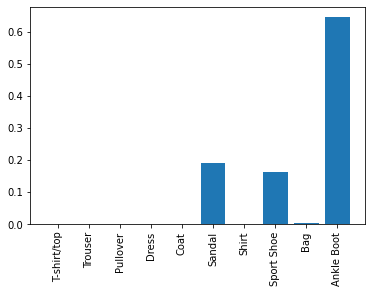

In [9]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoe','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

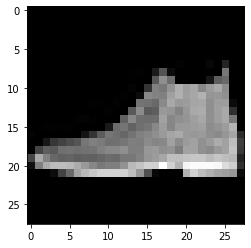

In [10]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor
  
img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')